In [32]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

import phenom

import lal
import lalsimulation as lalsim

import lalutils

In [33]:
import surrogate
import greedyrb
import gprfit
import george

# data acquisition

We need a function that we can call to
generate data in a uniform way.

We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [34]:
def gen_1d_massratio_data(q_array, M, deltaF=1/8., f_min=30, f_max=200,
                         approximant=lalsim.IMRPhenomD, inclination=0):

    data = []
    coords = []
    
    for q in q_array:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaF=deltaF,
                  f_min=f_min, f_max=f_max,
                  inclination=inclination,
                  approximant=approximant
                 )
        p = lalutils.gen_wf_params(**pp)
        f, _, _, phase = lalutils.gen_wf(p)
        d = {"f":f, "phase":phase}
#         f, _, amp, phase = lalutils.gen_wf(p)
#         d = {"f":f, "phase":phase, "amp":amp}
        data.append(d)
        coords.append([q])
    
    new_f = []
    new_y = []
    
    # subtract linear piece from phase
    for i in range(len(data)):
        
        f = data[i]['f']
        y = data[i]['phase']
#         y = data[i]['amp']
        
#         mask = (f >= f_min) & (f <= f_max)
        mask = (f >= f_min) & (f <= f_max)

        z = np.polyfit(f[mask], y[mask], 1)
        p = np.poly1d(z)

        new_f.append(f)
        new_y.append(y - p(f))
#         new_f.append(f)
#         new_y.append(y)


    n_f_points = len(new_f[0])
    n_waveforms = len(new_f)
    ts = np.zeros(shape=(n_waveforms, n_f_points))
    
    x = new_f[0]
    for i in range(n_waveforms):
        ts[i] = new_y[i]
        
    return x, ts, np.array(coords)

In [35]:
seed_x, seed_ts, seed_ts_coords = gen_1d_massratio_data(np.linspace(1,10,3), 100)

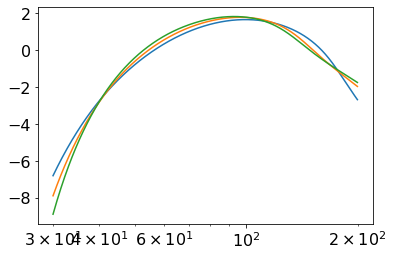

In [36]:
plt.figure()
for s in seed_ts:
    plt.plot(seed_x, s)
plt.xscale('log')

# run

In [37]:
# Make integration rule

int_range = [seed_x[0], seed_x[-1]]
int_num = len(seed_x)

integration = greedyrb.Riemann(int_range, num=int_num)
x = integration.nodes  # Define x for convenience

In [38]:
sur = surrogate.Surrogate1D(integration)

In [39]:
sur.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)

building seed basis


In [40]:
sur.grb.greedy_points

array([[ 1. ],
       [ 5.5],
       [10. ]])

In [41]:
# check seed basis and add points
_, ts, ts_coords = gen_1d_massratio_data(np.random.uniform(1,10,100), 100)
sur.run_greedy_sweep(ts, ts_coords)

step = 0, error = 0.09983605438551946
step = 1, error = 0.001531693002557226
step = 2, error = 0.00018847894123386847
tolerance reached. exiting


In [42]:
# build eim
# eim needs to be built from training_set at the greedy points
_, ts, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), 100)

In [43]:
sur.build_eim(ts)

no yerr given - setting to zero
-142.10399350085703
-2.595408436055842


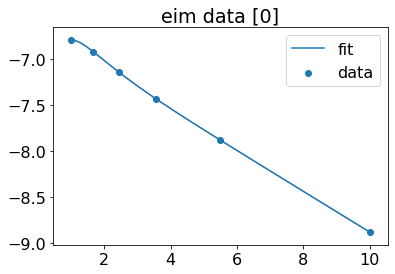

no yerr given - setting to zero
-47.797912507177074
3.4429501030496015


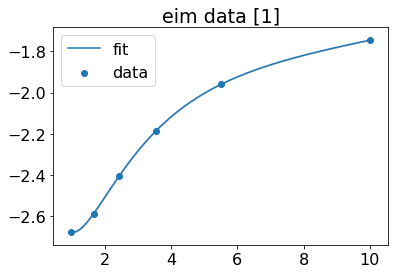

no yerr given - setting to zero
-6587.366118916652
2.498862543250042


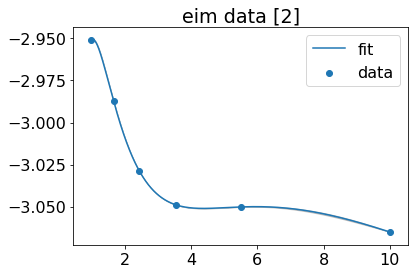

no yerr given - setting to zero
2.0218046912265066
4.951651322052272


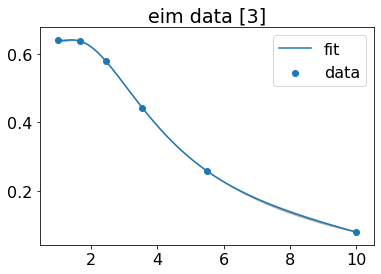

no yerr given - setting to zero
5.1051166591907755
6.37886758073745


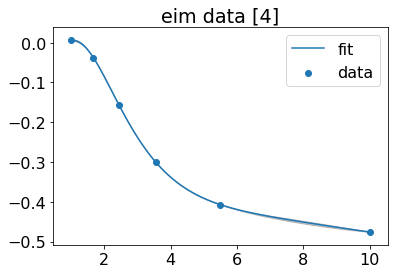

no yerr given - setting to zero
-101.91999323839951
1.771059946725937


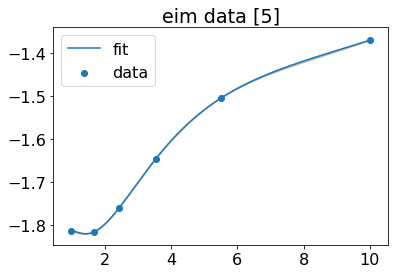

In [44]:
# fit_eim
solver=george.HODLRSolver
# solver=george.BasicSolver
sur.fit_eim(solver=solver)

In [46]:
sur.grb.nbasis

6

In [47]:
_, vts, vts_coords = gen_1d_massratio_data(np.random.uniform(1,10,100), 100)

In [48]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
print(f"worst case = {worst_case}")

worst case = [8.10216251]


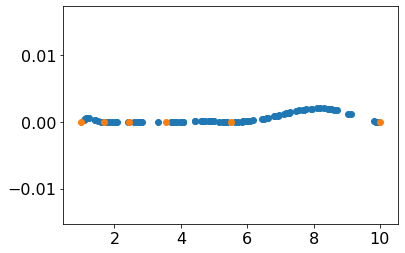

In [49]:
plt.figure()
plt.scatter(vts_coords, model_errors)
plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()

In [50]:
vts_worst = vts[worst_error_index]
vts_coords_worst = vts_coords[worst_error_index]

In [51]:
vts_worst.shape

(1360,)

In [52]:
vts_worst.reshape(1,-1)

array([[-8.46182374, -8.34576687, -8.23147196, ..., -1.80274321,
        -1.80647422, -1.8102038 ]])

In [53]:
# add the worst case to the basis and re-fit
sur.run_greedy_sweep(vts_worst.reshape(1,-1), vts_coords_worst.reshape(1, -1), greedy_tol=1e-7)

step = 0, error = 3.0685754815012714e-05


In [54]:
sur.grb.nbasis

7

In [55]:
# build eim
# eim needs to be built from training_set at the greedy points
_, ts, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), 100)

In [56]:
sur.build_eim(ts)

no yerr given - setting to zero
-152.82872704894467
3.903699943466842


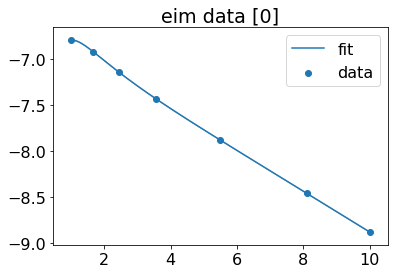

no yerr given - setting to zero
-43.33786531251208
5.022324818135177


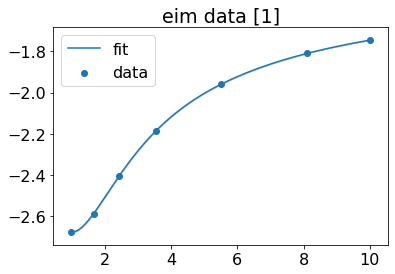

no yerr given - setting to zero
-7758.442788992931
8.669812189372776


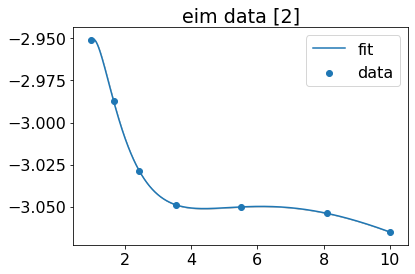

no yerr given - setting to zero
6.274922138998027
9.47870713670166


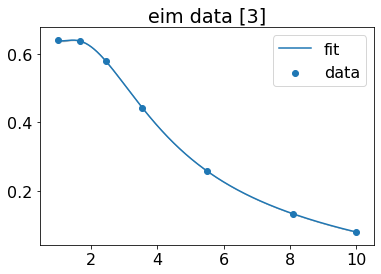

no yerr given - setting to zero
9.11461658444737
10.777721123628611


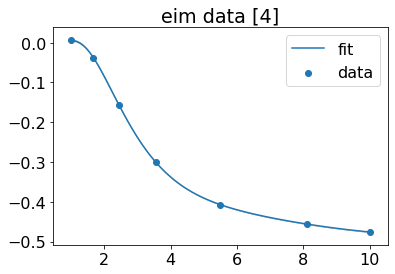

no yerr given - setting to zero
-94.39123003086904
4.087401827308996


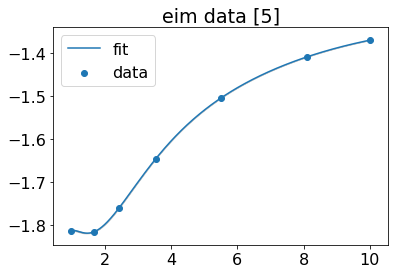

no yerr given - setting to zero
-178.84317141333406
8.076833503809985


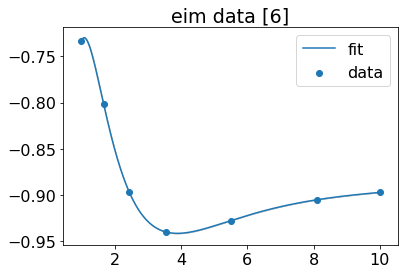

In [57]:
# fit_eim
solver=george.HODLRSolver
# solver=george.BasicSolver
sur.fit_eim(solver=solver)

In [58]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
print(f"worst case = {worst_case}")

worst case = [1.19797676]


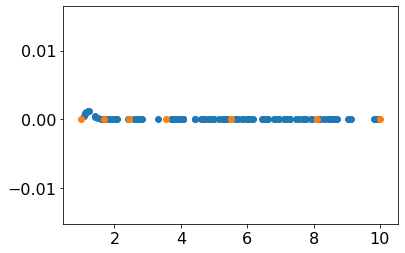

In [59]:
plt.figure()
plt.scatter(vts_coords, model_errors)
plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()